In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

from trader import *
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
df = pd.read_csv('CDD/gemini_BTCUSD_1hr.csv')
df = df.reset_index()
df.columns = df.iloc[0]#['dt', 'date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
df = df.iloc[1:].sort_values('Date').reset_index(drop=True)
for col in df.columns[-5:]:
    df.loc[:, col] = df[col].astype(float)

price_df = df
price_df['DT'] = pd.to_datetime(price_df.Date)
price_df['Date'] = price_df.DT.dt.date


In [7]:
WINDOW_SIZES = [7, 14, 28, 56, 224, 700, 1400]

def add_ewm(df, price_col='Close'):
    for ws in WINDOW_SIZES:
        ewm = df[price_col].ewm(span=ws).mean()
        df.loc[:, f'ewm_{ws}'] = ewm

add_ewm(price_df, price_col='Close')

from sklearn.linear_model import Lasso
def add_exp_trend(df, price_col='Close'):
    xs = np.array(list(df.index))
    ys = np.log(df.Close.values)

    model = Lasso()
    model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
    preds = model.predict(xs.reshape(-1, 1))

    a = model.coef_[0]
    b = preds[0] - xs[0] * a
    df.loc[:, 'exp_trend'] = np.exp(preds)
    return a, b

# add_exp_trend(price_df)

def plot(df, cols, dt_col='DT', buy_column=None, sell_column=None, height=0.0005, name='graph'):
    plt.figure(figsize=(20,10))
    for col in cols:
        plt.plot(df[dt_col], df[col])

    
    if buy_column is not None:
        buy_df = df[df[buy_column].astype(int) > 0]
        plt.vlines(buy_df.DT, buy_df.Close*(1-height), buy_df.Close*(1+height), colors='green')

    if sell_column is not None:
        sell_df = df[df[sell_column].astype(int) > 0]
        plt.vlines(sell_df.DT, sell_df.Close*(1-height), sell_df.Close*(1+height), colors='green')

    plt.legend(cols)
    plt.savefig(f'{name}.png', format='png')
    plt.show()

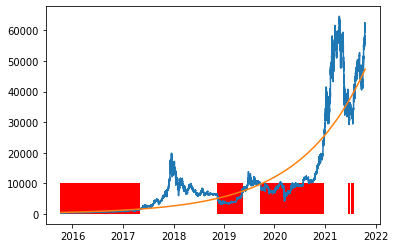

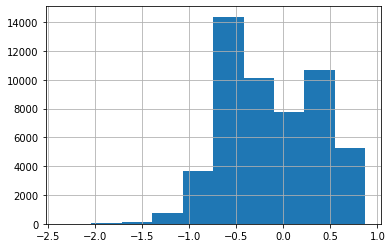

In [4]:
add_exp_trend(price_df)
delta = price_df.Close - price_df.exp_trend
delta_pct = delta / price_df.Close

trend_threshold = -0.2
price_df['delta_pct'] = delta_pct
price_df['indicator'] = (delta_pct < trend_threshold).astype(int)

plt.plot(price_df.DT, price_df.Close)
plt.plot(price_df.DT, price_df.exp_trend)
plt.vlines(price_df[price_df.indicator == 1].DT, 0, 10000, colors='r')
plt.show()

delta_pct.hist()
plt.show()

# evaluate EXP_trend by period

In [12]:
def evaluate_indicator(df, price_col='Close', indicator_col='indicator', invest_period=30*24):
    price = df[price_col]
    start_price = price.iloc[0]
    end_price = price.iloc[-1]
    min_price = price.min()
    max_price = price.max()

    ind2buy_periodic = df.index[::invest_period]
    periodic_price = price[ind2buy_periodic].mean()

    criterion_price = price[df[indicator_col] > 0].mean()

    res_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])
    res_df['price'] = [min_price, start_price, periodic_price, criterion_price, max_price, end_price]
    res_df['gain_pct'] = (end_price / res_df.price * 100 - 100).round(1)
    return res_df

In [11]:
compare_df_after = evaluate_indicator(price_df)[['gain_pct']]
compare_df_after.columns = ['total']
compare_df_after.loc['num_activation_hours', 'total'] = price_df.indicator.sum()
compare_df_after.loc['num_activation_dates', 'total'] = len(price_df[price_df.indicator > 0].DT.dt.date.unique())

for year in range(2015, 2022):
    slice = price_df[price_df.DT.dt.year == year]
    res = evaluate_indicator(slice)
    compare_df_after[year] = res.gain_pct
    compare_df_after.loc['num_activation_hours', year] = slice.indicator.sum()
    compare_df_after.loc['num_activation_dates', year] = len(slice[slice.indicator > 0].DT.dt.date.unique())

compare_df_after

,total,2015,2016,2017,2018,2019,2020,2021
best,25145.5,76.5,174.1,1717.5,17.6,113.8,596.6,111.5
buy&hold,25001.3,75.5,126.7,1321.8,-72.8,93.9,305.4,111.5
periodic,446.3,24.9,70.1,240.2,-51.9,0.9,153.6,42.1
criterion,1153.5,22.1,73.1,1230.9,-1.3,29.2,176.4,95.5
worst,-4.8,-13.5,-0.8,-30.4,-78.5,-48.2,-0.7,-4.8
end,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_activation_hours,27354.0,1960.0,8573.0,2253.0,937.0,4993.0,8420.0,218.0
num_activation_dates,1166.0,85.0,360.0,103.0,42.0,213.0,351.0,12.0


# evaluate EXP trend honestly, refitting every month

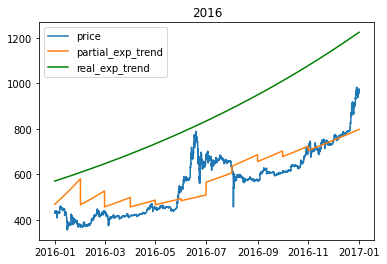

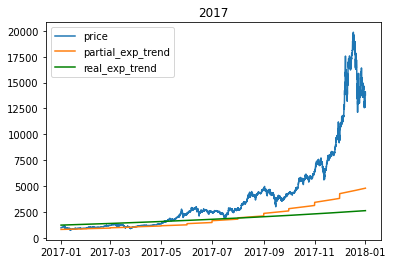

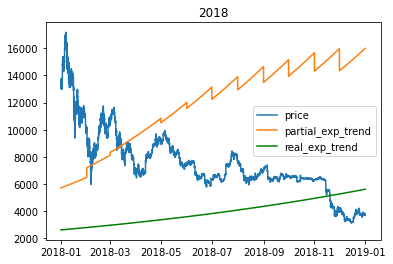

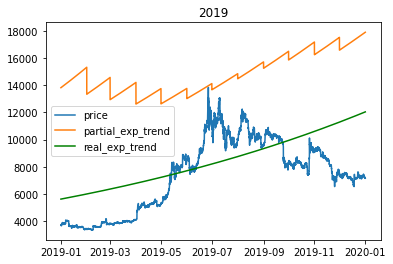

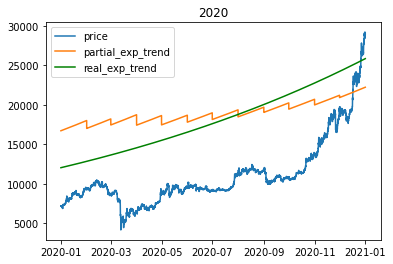

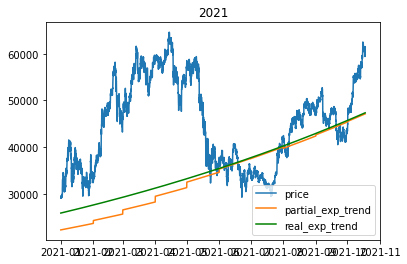

,2016,2017,2018,2019,2020,2021
best,174.1,1717.5,17.6,113.8,596.6,111.5
buy&hold,126.7,1321.8,-72.8,93.9,305.4,111.5
periodic,70.1,240.2,-51.9,0.9,153.6,42.1
criterion,147.7,NaN,-42.0,-1.1,195.6,95.5
worst,-0.8,-30.4,-78.5,-48.2,-0.7,-4.8
end,0.0,0.0,0.0,0.0,0.0,0.0
num_activation_hours,1010.0,0.0,6222.0,8568.0,7778.0,215.0
num_activation_dates,53.0,0.0,265.0,362.0,327.0,12.0


In [20]:
# compare_df = evaluate_indicator(price_df)[['gain_pct']]
# compare_df.columns = ['total']
# compare_df.loc['num_activation_hours', 'total'] = price_df.indicator.sum()
# compare_df.loc['num_activation_dates', 'total'] = len(price_df[price_df.indicator > 0].DT.dt.date.unique())
compare_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])

for year in range(2016, 2022):
    
    slices = []
    for month in range(1, 13):
        first_day = dt.datetime(year=year, month=month, day=1, hour=0)
        last_day = first_day + relativedelta(months=1)

        slice = price_df[price_df.DT < first_day].copy()
        a, b = add_exp_trend(slice)
        
        slice = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()
        slice['exp_trend'] = np.exp(a * np.array(list(slice.index)) + b)
        # print(slice.exp_trend)
        slices.append(slice)

    slice = pd.concat(slices)
    # print(slice.head())

    plt.plot(slice.DT, slice.Close)
    plt.plot(slice.DT, slice.exp_trend)
    plt.plot(slice.DT, price_df.loc[slice.index].exp_trend, c='g')
    plt.legend(['price', 'partial_exp_trend', 'real_exp_trend'])
    plt.title(year)
    plt.show()
    
    trend_threshold = -0.2
    delta_pct = (slice.Close - slice.exp_trend) / slice.Close
    slice['indicator'] = (delta_pct < trend_threshold).astype(int)

    res = evaluate_indicator(slice)
    compare_df[year] = res.gain_pct
    compare_df.loc['num_activation_hours', year] = slice.indicator.sum()
    compare_df.loc['num_activation_dates', year] = len(slice[slice.indicator > 0].DT.dt.date.unique())

compare_df

In [24]:
performance_exp_trend = compare_df

In [53]:
compare_df_after

,total,2015,2016,2017,2018,2019,2020,2021
best,25145.5,76.5,174.1,1717.5,17.6,113.8,596.6,111.5
buy&hold,25001.3,75.5,126.7,1321.8,-72.8,93.9,305.4,111.5
periodic,446.3,24.9,70.1,240.2,-51.9,0.9,153.6,42.1
criterion,1153.5,22.1,73.1,1230.9,-1.3,29.2,176.4,95.5
worst,-4.8,-13.5,-0.8,-30.4,-78.5,-48.2,-0.7,-4.8
end,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_activation_hours,27354.0,1960.0,8573.0,2253.0,937.0,4993.0,8420.0,218.0
num_activation_dates,1166.0,85.0,360.0,103.0,42.0,213.0,351.0,12.0


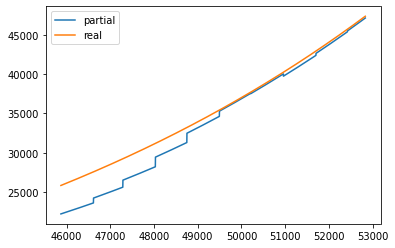

In [19]:
slice.exp_trend.plot()
price_df.loc[slice.index].exp_trend.plot()
plt.legend(['partial', 'real'])
plt.show()

# evaluate trader

In [28]:
from trader import *
from sklearn.ensemble import GradientBoostingRegressor


feature_columns = EWM_DELTA_COLS + ['ewm_delta_sum', 'ewm_delta_mean', 'exp_trend_delta']

def get_increase_pct(prices, horizon=30):
    res = np.vstack([prices.shift(-i).values for i in range(horizon)])
    max_value_in_horizon = np.nanmax(res, axis=0)
    return max_value_in_horizon / prices

from sklearn.linear_model import Lasso

def mse(pred, true):
    return ((pred - true)**2).mean()

def mae(pred, true):
    return (np.abs(pred - true)).mean()

def mape(pred, true):
    return (np.abs(pred - true) / np.abs(true)).mean()

# Fit (find trend) on all past years

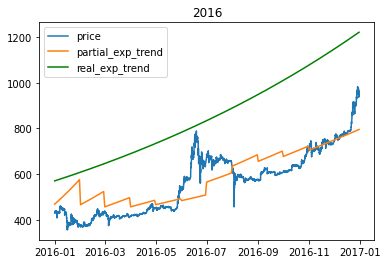

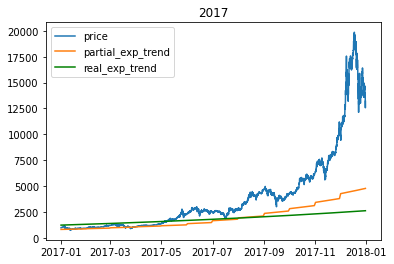

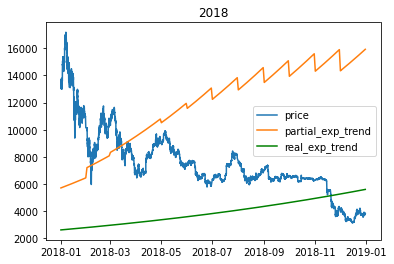

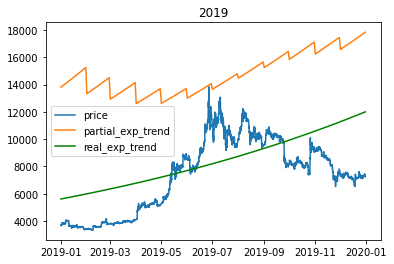

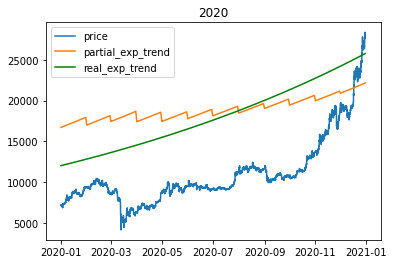

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required.

In [34]:
compare_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])
horizon = 30

for year in range(2016, 2021):
    
    tests = []
    for month in range(1, 13):
        first_day = dt.datetime(year=year, month=month, day=1, hour=0)
        last_day = first_day + relativedelta(months=1)

        train = price_df[price_df.DT < first_day].copy()

        t = Trader()
        t.fit(train)

        train = t.price_df
        a, b = add_exp_trend(train, 'price')
        
        test = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()

        t = Trader()
        t.fit(test)
        test = t.price_df.drop(['exp_trend'], axis=1)
        test['exp_trend'] = np.exp(a * np.array(list(test.index)) + b)

        
        X_train = train[feature_columns].iloc[:-horizon]
        X_test = test[feature_columns].iloc[:-horizon]
        y_train = get_increase_pct(train.price, horizon)[:-horizon]
        y_test = get_increase_pct(test.price, horizon)[:-horizon]


        model = GradientBoostingRegressor(n_estimators=100)
        model.fit(X_train.values, y_train.values)

        pred_train = model.predict(X_train.values)
        true_train = y_train.values

        pred_test = model.predict(X_test.values)
        true_test = y_test.values

        test = test.iloc[:-horizon]
        test['indicator'] = pred_test > 1.1

        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on train: ', func(pred_train, true_train))
        # print()
        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on test: ', func(pred_test, true_test))

        tests.append(test)

    test = pd.concat(tests)
    # print(test.head())

    plt.plot(test.DT, test.price)
    plt.plot(test.DT, test.exp_trend)
    plt.plot(test.DT, price_df.loc[test.index].exp_trend, c='g')
    plt.legend(['price', 'partial_exp_trend', 'real_exp_trend'])
    plt.title(year)
    plt.show()
    
    # trend_threshold = -0.2
    # delta_pct = (test.Close - test.exp_trend) / test.Close
    # test['indicator'] = (delta_pct < trend_threshold).astype(int)

    res = evaluate_indicator(test, price_col='price')
    compare_df[year] = res.gain_pct
    compare_df.loc['num_activation_hours', year] = test.indicator.sum()
    compare_df.loc['num_activation_dates', year] = len(test[test.indicator > 0].DT.dt.date.unique())

compare_df

# Fit (find trend) only on last year

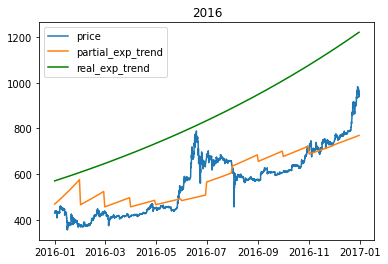

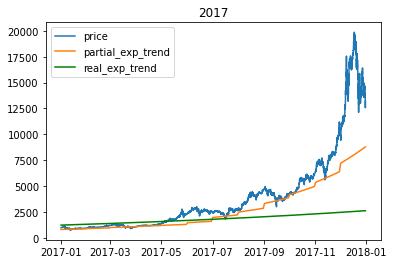

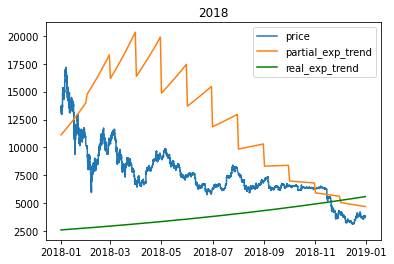

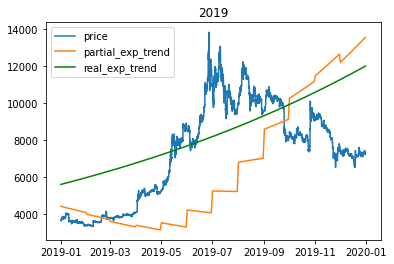

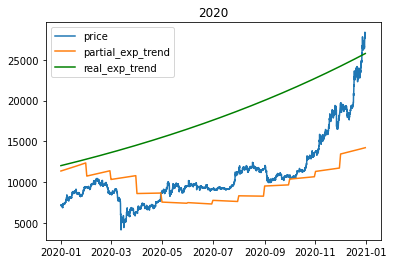

,2016,2017,2018,2019,2020
best,170.8,1635.0,21.5,116.1,579.3
buy&hold,124.0,1257.3,-71.9,95.9,295.3
periodic,74.1,241.2,-52.1,-0.0,168.5
criterion,123.8,120.3,-43.6,-23.9,309.6
worst,-2.0,-33.6,-77.8,-47.7,-0.4
end,0.0,0.0,0.0,0.0,0.0
num_activation_hours,25.0,74.0,702.0,8.0,793.0
num_activation_dates,10.0,16.0,48.0,2.0,46.0


In [16]:
compare_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])
horizon = 30

for year in range(2016, 2021):
    
    tests = []
    for month in range(1, 13):
        first_day = dt.datetime(year=year, month=month, day=1, hour=0)
        last_day = first_day + relativedelta(months=1)
        year_ago = first_day - relativedelta(years=1)

        train = price_df[(price_df.DT < first_day) & (price_df.DT > year_ago)].copy()

        t = Trader()
        t.fit(train)

        train = t.price_df
        a, b = add_exp_trend(train, 'price')
        
        test = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()

        t = Trader()
        t.fit(test)
        test = t.price_df.drop(['exp_trend'], axis=1)
        test['exp_trend'] = np.exp(a * np.array(list(test.index)) + b)

        
        X_train = train[feature_columns].iloc[:-horizon]
        X_test = test[feature_columns].iloc[:-horizon]
        y_train = get_increase_pct(train.price, horizon)[:-horizon]
        y_test = get_increase_pct(test.price, horizon)[:-horizon]


        model = GradientBoostingRegressor(n_estimators=100)
        model.fit(X_train.values, y_train.values)

        pred_train = model.predict(X_train.values)
        true_train = y_train.values

        pred_test = model.predict(X_test.values)
        true_test = y_test.values

        test = test.iloc[:-horizon]
        test['indicator'] = pred_test > 1.1

        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on train: ', func(pred_train, true_train))
        # print()
        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on test: ', func(pred_test, true_test))

        tests.append(test)

    test = pd.concat(tests)
    # print(test.head())

    plt.plot(test.DT, test.price)
    plt.plot(test.DT, test.exp_trend)
    plt.plot(test.DT, price_df.loc[test.index].exp_trend, c='g')
    plt.legend(['price', 'partial_exp_trend', 'real_exp_trend'])
    plt.title(year)
    plt.show()
    
    # trend_threshold = -0.2
    # delta_pct = (test.Close - test.exp_trend) / test.Close
    # test['indicator'] = (delta_pct < trend_threshold).astype(int)

    res = evaluate_indicator(test, price_col='price')
    compare_df[year] = res.gain_pct
    compare_df.loc['num_activation_hours', year] = test.indicator.sum()
    compare_df.loc['num_activation_dates', year] = len(test[test.indicator > 0].DT.dt.date.unique())

compare_df

# refit every week

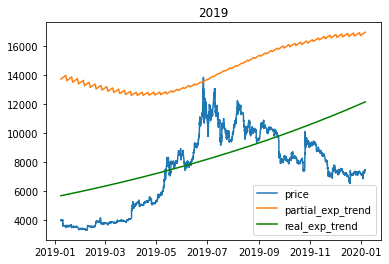

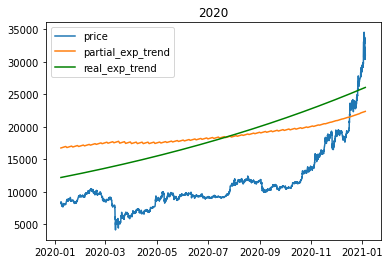

,2019,2020
best,122.7,645.8
buy&hold,86.0,267.4
periodic,-0.6,192.0
criterion,46.8,420.1
worst,-46.1,-10.1
end,0.0,0.0
num_activation_hours,44.0,127.0
num_activation_dates,5.0,13.0


In [20]:
compare_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])
horizon = 30

for year in range(2019, 2021):
    
    tests = []
    
    week = relativedelta(weeks=1)
    first_day = dt.datetime(year=year, month=1, day=1, hour=0)
    last_day = first_day + week
    while last_day.year == year:
        first_day += week
        last_day += week

        train = price_df[price_df.DT < first_day].copy()

        t = Trader()
        t.fit(train)

        train = t.price_df
        a, b = add_exp_trend(train, 'price')
        
        test = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()

        t = Trader()
        t.fit(test)
        test = t.price_df.drop(['exp_trend'], axis=1)
        test['exp_trend'] = np.exp(a * np.array(list(test.index)) + b)

        
        X_train = train[feature_columns].iloc[:-horizon]
        X_test = test[feature_columns].iloc[:-horizon]
        y_train = get_increase_pct(train.price, horizon)[:-horizon]
        y_test = get_increase_pct(test.price, horizon)[:-horizon]


        model = GradientBoostingRegressor(n_estimators=100)
        model.fit(X_train.values, y_train.values)

        pred_train = model.predict(X_train.values)
        true_train = y_train.values

        pred_test = model.predict(X_test.values)
        true_test = y_test.values

        test = test.iloc[:-horizon]
        test['indicator'] = pred_test > 1.1

        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on train: ', func(pred_train, true_train))
        # print()
        # for name, func in zip(['MSE', 'MAE', 'MAPE'], [mae, mse, mape]):
        #     print(f'{name} on test: ', func(pred_test, true_test))

        tests.append(test)

    test = pd.concat(tests)
    # print(test.head())

    plt.plot(test.DT, test.price)
    plt.plot(test.DT, test.exp_trend)
    plt.plot(test.DT, price_df.loc[test.index].exp_trend, c='g')
    plt.legend(['price', 'partial_exp_trend', 'real_exp_trend'])
    plt.title(year)
    plt.show()
    
    # trend_threshold = -0.2
    # delta_pct = (test.Close - test.exp_trend) / test.Close
    # test['indicator'] = (delta_pct < trend_threshold).astype(int)

    res = evaluate_indicator(test, price_col='price')
    compare_df[year] = res.gain_pct
    compare_df.loc['num_activation_hours', year] = test.indicator.sum()
    compare_df.loc['num_activation_dates', year] = len(test[test.indicator > 0].DT.dt.date.unique())

compare_df

In [17]:
# fit only on last year
compare_df

,2016,2017,2018,2019,2020
best,170.8,1635.0,21.5,116.1,579.3
buy&hold,124.0,1257.3,-71.9,95.9,295.3
periodic,74.1,241.2,-52.1,-0.0,168.5
criterion,123.8,120.3,-43.6,-23.9,309.6
worst,-2.0,-33.6,-77.8,-47.7,-0.4
end,0.0,0.0,0.0,0.0,0.0
num_activation_hours,25.0,74.0,702.0,8.0,793.0
num_activation_dates,10.0,16.0,48.0,2.0,46.0


In [35]:
# fit on all past years, refit every month
compare_df

,2016,2017,2018,2019,2020
best,170.8,1635.0,21.5,116.1,579.3
buy&hold,124.0,1257.3,-71.9,95.9,295.3
periodic,74.1,241.2,-52.1,-0.0,168.5
criterion,122.7,41.4,-49.8,41.8,387.2
worst,-2.0,-33.6,-77.8,-47.7,-0.4
end,0.0,0.0,0.0,0.0,0.0
num_activation_hours,27.0,103.0,420.0,41.0,258.0
num_activation_dates,9.0,18.0,32.0,5.0,20.0


In [ ]:
# fit on all past, refit every week
compare_df

In [36]:
# take only exp trend
performance_exp_trend

,2016,2017,2018,2019,2020,2021
best,174.1,1717.5,17.6,113.8,596.6,111.5
buy&hold,126.7,1321.8,-72.8,93.9,305.4,111.5
periodic,70.1,240.2,-51.9,0.9,153.6,42.1
criterion,147.7,NaN,-42.0,-1.1,195.6,95.5
worst,-0.8,-30.4,-78.5,-48.2,-0.7,-4.8
end,0.0,0.0,0.0,0.0,0.0,0.0
num_activation_hours,1010.0,0.0,6222.0,8568.0,7778.0,215.0
num_activation_dates,53.0,0.0,265.0,362.0,327.0,12.0
